In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


In [2]:
limit_mem()

In [3]:
from keras.datasets.cifar10 import load_batch

#### We are implementing densenet with cifar10 datasets based on paper by Huang et al.  densenet is simply resenet with replacing addition with concatenation

#### Idea
Recall that in broad terms, a Resnet is a Convnet that uses residual block structures.
These "blocks" work as follows:
Let Lt be the input layer to block
Perform conv layer transformations/activations on Lt, denote by f(t)
Call output layer of block Lt+1
Define Lt+1 = f(Lt)+ Lt
That is, total output is the conv layer outputs plus the original input
We call residual block b.c. f(Lt)=Lt+1 - Lt, the residual
As mentioned, the difference w/ DenseNet is instead of adding Lt to Lt+1, it is being concatenated.
As with Resnet, DenseNet consists of multiple blocks. Therefore, there is a recursive relationship across blocks:
Block Bi takes as input the ouput of block Bi-1 concatenated with the input of Bi-1
The input to Bi-1 is the ouput of block Bi-2 concatenated with the input of Bi-2
So on and so forth
The number of filters added to each layer needs to be monitored, given that the input space for each block keeps growing.
Huang et al. calls the # of filters added at each layer the growth rate, and appropriately denotes this num

In [4]:
def load_data():
    path = "/users/trinakarmakar/anaconda2/data/cifar-10-batches-py"
    num_train_samples = 50000
    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')
    for i in range(1, 6):
        data, labels = load_batch(os.path.join(path, 'data_batch_' + str(i)))
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels  
    x_test , y_test = load_batch(os.path.join(path, 'test_batch'))
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test),1))
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [5]:
(x_train, y_train), (x_test, y_test) = load_data()

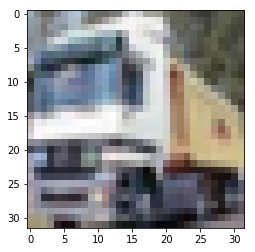

In [6]:
plt.imshow(x_train[1])

In [7]:
#We wnat to normalize pixel values (0-255) to unit interval
x_train = x_train / 255.
x_test = x_test / 255.

In [8]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=0, axis=1)(x)
def relu_bn(x): return relu(bn(x))

In [9]:
def conv(x, nf, sz, wd, p):
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same',
                     W_regularizer=l2(wd))(x)
    return dropout(x,p)

### Define ConvBlock as sequence:
Batchnorm
ReLU Activation
Conv layer (conv w/ Dropout)
The authors also use something called a bottleneck layer to reduce dimensionality of inputs.
Recall that the filter space dimensionality grows at each block. The input dimensionality will determine the dimensionality of your convolution weight matrices, i.e. # of parameters.
At size 3x3 or larger, convolutions can become extremely costly and # of parameters can increase quickly as a function of the input feature (filter) space. Therefore, a smart approach is to reduce dimensionality of filters by using a 1x1 convolution w/ smaller # of filters before the larger convolution.
Bottleneck consists of:

1x1 conv

Compress # of filters into growth factor nf * 4

Batchnorm -> ReLU

In [10]:
def conv_block(x, nf, bottleneck=False, p=None, wd=0):
    x = relu_bn(x)
    if bottleneck:
        x = relu_bn(conv(x, nf * 4, 1, wd, p))
    return conv(x, nf, 3, wd, p) 

In [11]:
def dense_block(x, nb_layers, growth_rate, bottleneck=False, p=None, wd=0):
    if bottleneck:
        nb_layers //=2
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p = p, wd=wd)
        x = merge([x, b], mode='concat', concat_axis=-1)
    return x

#### As typical for CV architectures, we'll do some pooling after computation.
We'll define this unit as the transition block, and we'll put one between each dense block.
Aside from BN -> ReLU and Average Pooling, there is also an option for filter compression in this block. This is simply feature reduction via 1x1 conv as discussed before, where the new # of filters is a percentage of the incoming # of filters.
Together with bottleneck, compression has been shown to improve performance and computational efficiency of DenseNet architectures. (the authors call this DenseNet-BC)

In [12]:
def transition_block(x, compression=1.0, p = None, wd=0):
    nf = int(x.get_shape().as_list()[-1] * compression)
    x = relu_bn(x) 
    x = conv(x, nf, 1, wd, p)
    return AveragePooling2D((2,2), strides=(2,2))(x)

### Build the DenseNet model
#### We've now defined all the building blocks (literally) to put together a DenseNet.
nb_classes: number of classes
img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
depth: total number of layers
Includes 4 extra non-block layers
1 input conv, 3 output layers
nb_block: number of dense blocks (generally = 3).
NOTE: Layers / block are evenly allocated. Therefore nb_block must be a factor of (Depth - 4)
growth_rate: number of filters to add per dense block
nb_filter: initial number of filters
bottleneck: add bottleneck blocks
Compression: Filter compression factor in transition blocks.
p: dropout rate
wd: weight decay
activation: Type of activation at the top layer. Can be one of 'softmax' or 'sigmoid'. Note that if sigmoid is used, classes must be 1.

Returns: keras tensor with nb_layers of conv_block appended
From start to finish, this generates:
Conv input layer
Alternate between Dense/Transition blocks nb_block times, ommitting Transition block after last Dense block
Each Dense block has (Depth-4)/nb_block layers
Pass final Dense block to BN -> ReLU
Global Avg Pooling
Dense layer w/ desired output activation

In [13]:
def create_dense_net(nb_classes, img_output, depth=40, nb_block=3,
                    growth_rate=12, nb_filter=16, bottleneck=False, compression=1.0,
                    p = None, wd=0, activation='softmax'):
    assert activation == 'softmax' or axtivation == 'sigmoid'
    assert (depth - 4) % nb_block == 0
    nb_layers_per_block = int((depth - 4) / nb_block)
    nb_layers = [nb_layers_per_block] * nb_block
    
    x = conv(img_input, nb_filter, 3, wd, 0)
    for i, block in enumerate(nb_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd = wd)
        if i != len(nb_layers) - 1:
            x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
            if i != len(nb_layers)-1:
                x = transition_block(x, compression=compression, p=p, wd=wd)
            
        
    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    return Dense(nb_classes, activation=activation, W_regulaizer=l2(wd))(x)

In [14]:
input_shape = (32,32,3)

In [15]:
img_input = Input(shape=input_shape)

In [16]:
x = create_dense_net(10, img_input, depth=100, nb_filter=16,
                    compression=0.5, bottleneck=True, wd=1e-4)

/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), kernel_regularizer=<keras.reg..., kernel_initializer="he_uniform", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/trinakarmakar/anaconda2/envs/dl4nlp/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 1), kernel_regularizer=<keras.reg..., kernel_initializer="he_uniform", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/trinakarmakar/anaconda2/envs/dl4n

TypeError: ('Keyword argument not understood:', 'W_regulaizer')

In [ ]:
model = Model(img_input)